# Configure Preprocessing Params

This notebook should be used to set up preprocessing params.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [1]:
import re
from pathlib import Path
from itertools import chain

import pandas as pd
import yaml
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt

from lib.shared.configuration_utils import CONFIG_FILE_HEADER, create_micropanel
from lib.preprocess.preprocess import extract_tile_metadata, nd2_to_tiff

## SET PARAMETERS

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing*.
- `ROOT_FP`: Path to root of Brieflow output directory*.

*Note: Paths can be absolute or relative to where workflows are run from.

In [2]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "analysis_root/"

## SET PARAMETERS

### Paths to dataframes with sample information

- `SBS_SAMPLES_DF_FP`/`PHENOTYPE_SAMPLES_DF_FP`: Path to dataframe with SBS/phenotype samples location and metadata*.
- `SBS_DATA_FP`/`PHENOTYPE_DATA_FP`: Path to directories with SBS/phenotype sample nd2 files*.
- `SBS_SAMPLE_PATTERN`/`PHENOTYPE_SAMPLE_PATTERN`: Regex patterns to match SBS/phenotype sample nd2 files.

*Note: Paths can be absolute or relative to where workflows are run from.

In [3]:
# paths to sample dataframes
SBS_SAMPLES_DF_FP = "config/sbs_samples.tsv"
PHENOTYPE_SAMPLES_DF_FP = "config/phenotype_samples.tsv"

# directories with SBS/phenotype sample nd2 files
SBS_REAL_IMAGES_FP = Path("data/real_images/sbs/")
SBS_EMPTY_IMAGES_FP = Path("data/empty_images/sbs/")
PHENOTYPE_REAL_IMAGES_FP = Path("data/real_images/phenotype/")
PHENOTYPE_EMPTY_IMAGES_FP = Path("data/empty_images/phenotype/")

# Patterns to match SBS/phenotype sample nd2 files
SBS_SAMPLE_PATTERN = r"C(\d+)_Wells-([A-Z]\d+)_Points-(\d+)"
PHENOTYPE_SAMPLE_PATTERN = r"Wells-([A-Z]\d+)_Points-(\d+)"

"""
We use the following LLM prompt to generate the example sample patterns:

Given the following ND2 file names, create two regular expressions (regex) as raw string literals to extract specific components from the filenames. The regex patterns should be assigned to the variables `SBS_SAMPLE_PATTERN` and `PHENOTYPE_SAMPLE_PATTERN` as follows:

1. `SBS_SAMPLE_PATTERN`: Extract the following components from SBS filenames:
   - Cycle number ("C" then a number)
   - Well identifier ("Wells-" then a letter and a number)
   - Tile number ("Points-" then a number)
Example SBS ND2 file name: P001_SBS_10x_C9_Wells-A1_Points-100__Channel_Cy7,Cy5,AF594,Cy3_SBS,DAPI_SBS.nd2   

2. `PHENOTYPE_SAMPLE_PATTERN`: Extract the following components from Phenotype filenames:
   - Well identifier ("Wells-" then a letter and a number)
   - Tile number ("Points-" then a number)
Example Phenotype ND2 file name: P001_Pheno_20x_Wells-A1_Points-001__Channel_AF750,Cy3,GFP,DAPI.nd2

We want to use these regex patterns to match files and find information like below:
for file in chain(SBS_REAL_IMAGES_FP.iterdir(), SBS_EMPTY_IMAGES_FP.iterdir()):
    match = re.search(SBS_SAMPLE_PATTERN, file.name)
    if match:
        cycle = int(match.group(1))
        well = match.group(2)
        tile = int(match.group(3))
"""

'\nWe use the following LLM prompt to generate the example sample patterns:\n\nGiven the following ND2 file names, create two regular expressions (regex) as raw string literals to extract specific components from the filenames. The regex patterns should be assigned to the variables `SBS_SAMPLE_PATTERN` and `PHENOTYPE_SAMPLE_PATTERN` as follows:\n\n1. `SBS_SAMPLE_PATTERN`: Extract the following components from SBS filenames:\n   - Cycle number ("C" then a number)\n   - Well identifier ("Wells-" then a letter and a number)\n   - Tile number ("Points-" then a number)\nExample SBS ND2 file name: P001_SBS_10x_C9_Wells-A1_Points-100__Channel_Cy7,Cy5,AF594,Cy3_SBS,DAPI_SBS.nd2   \n\n2. `PHENOTYPE_SAMPLE_PATTERN`: Extract the following components from Phenotype filenames:\n   - Well identifier ("Wells-" then a letter and a number)\n   - Tile number ("Points-" then a number)\nExample Phenotype ND2 file name: P001_Pheno_20x_Wells-A1_Points-001__Channel_AF750,Cy3,GFP,DAPI.nd2\n\nWe want to use th

## Create Sample DFs

In [4]:
# List to store file information
sbs_data = []

# Iterate over files and extract information
for file in chain(SBS_REAL_IMAGES_FP.iterdir(), SBS_EMPTY_IMAGES_FP.iterdir()):
    match = re.search(SBS_SAMPLE_PATTERN, file.name)
    if match:
        cycle = int(match.group(1))
        well = match.group(2)
        tile = int(match.group(3))

        sbs_data.append(
            {"sample_fp": str(file), "well": well, "tile": tile, "cycle": cycle}
        )

# Create a DataFrame and sort by well, tile, and cycle
sbs_samples = pd.DataFrame(sbs_data)
sbs_samples = sbs_samples.sort_values(by=["well", "tile", "cycle"])
sbs_samples = sbs_samples.reset_index(drop=True)

sbs_samples.to_csv(SBS_SAMPLES_DF_FP, sep="\t", index=False)
print("SBS samples:")
display(sbs_samples)


# List to store file information
phenotype_data = []

# Iterate over files and extract information
for file in chain(
    PHENOTYPE_REAL_IMAGES_FP.iterdir(), PHENOTYPE_EMPTY_IMAGES_FP.iterdir()
):
    match = re.search(PHENOTYPE_SAMPLE_PATTERN, file.name)
    if match:
        well = match.group(1)
        tile = int(match.group(2))

        phenotype_data.append({"sample_fp": str(file), "well": well, "tile": tile})

# Create a DataFrame and sort by well, tile, and cycle
phenotype_samples = pd.DataFrame(phenotype_data)
phenotype_samples = phenotype_samples.sort_values(by=["well", "tile"])
phenotype_samples = phenotype_samples.reset_index(drop=True)

phenotype_samples.to_csv(PHENOTYPE_SAMPLES_DF_FP, sep="\t", index=False)
print("Phenotype samples:")
display(phenotype_samples)

SBS samples:


,sample_fp,well,tile,cycle
0,data/real_images/sbs/P001_SBS_10x_C1_Wells-A1_...,A1,1,1
1,data/real_images/sbs/P001_SBS_10x_C2_Wells-A1_...,A1,1,2
2,data/real_images/sbs/P001_SBS_10x_C3_Wells-A1_...,A1,1,3
3,data/real_images/sbs/P001_SBS_10x_C4_Wells-A1_...,A1,1,4
4,data/real_images/sbs/P001_SBS_10x_C5_Wells-A1_...,A1,1,5
...,...,...,...,...
61,data/real_images/sbs/P001_SBS_10x_C7_Wells-A2_...,A2,100,7
62,data/real_images/sbs/P001_SBS_10x_C8_Wells-A2_...,A2,100,8
63,data/real_images/sbs/P001_SBS_10x_C9_Wells-A2_...,A2,100,9
64,data/real_images/sbs/P001_SBS_10x_C10_Wells-A2...,A2,100,10


Phenotype samples:


,sample_fp,well,tile
0,data/real_images/phenotype/P001_Pheno_20x_Well...,A1,1
1,data/empty_images/phenotype/P003_Pheno_20x_Wel...,A1,2
2,data/real_images/phenotype/P001_Pheno_20x_Well...,A1,100
3,data/real_images/phenotype/P001_Pheno_20x_Well...,A2,1
4,data/empty_images/phenotype/P003_Pheno_20x_Wel...,A2,2
5,data/real_images/phenotype/P001_Pheno_20x_Well...,A2,100


## SET PARAMETERS

### Metadata extraction

- `SBS_Z_INTERVAL`/`PHENOTYPE_Z_INTERVAL`: Interval to sample z-planes to ensure metadata is one line per position. Integer or `None` for no sampling interval.

In [5]:
SBS_Z_INTERVAL = None
PHENOTYPE_Z_INTERVAL = None

## Test Metadata Extraction

In [ ]:
# Extract metadata from test sbs sample
print("SBS test metadata:")
test_sbs_metadata = extract_tile_metadata(
    sbs_samples["sample_fp"][0], sbs_samples["tile"][0], SBS_Z_INTERVAL
)
display(test_sbs_metadata)

# Extract metadata from test phenotype sample
print("Phenotype test metadata:")
test_phenotype_metadata = extract_tile_metadata(
    phenotype_samples["sample_fp"][0],
    phenotype_samples["tile"][0],
    PHENOTYPE_Z_INTERVAL,
)
display(test_phenotype_metadata)

SBS test metadata:


,x_data,y_data,z_data,pfs_offset,tile,filename,channels,pixel_size_x,pixel_size_y
0,[33049.0],[-35283.0],[3141.06],None,1,data/real_images/sbs/P001_SBS_10x_C1_Wells-A1_...,5,1.3,1.3


Phenotype test metadata:


,x_data,y_data,z_data,pfs_offset,tile,filename,channels,pixel_size_x,pixel_size_y
0,[41922.3],[-36839.3],[3162.6800000000003],None,1,data/real_images/phenotype/P001_Pheno_20x_Well...,4,0.325,0.325


## SET PARAMETERS

### ND2 conversion

- `SBS_CHANNEL_ORDER_FLIP`/`PHENOTYPE_CHANNEL_ORDER_FLIP`: Whether or not to flip channel order when converting ND2->tiff. Should be `False` if channels are in a standard order (with Dapi first), or `True` if channels are reversed.

**Note** Channel order can be checked with the test conversions below. Please ensure the Dapi channel is displayed first!

In [7]:
SBS_CHANNEL_ORDER_FLIP = True
PHENOTYPE_CHANNEL_ORDER_FLIP = True

## Test ND2 Conversion

### Test SBS conversion

Converted SBS test sample:


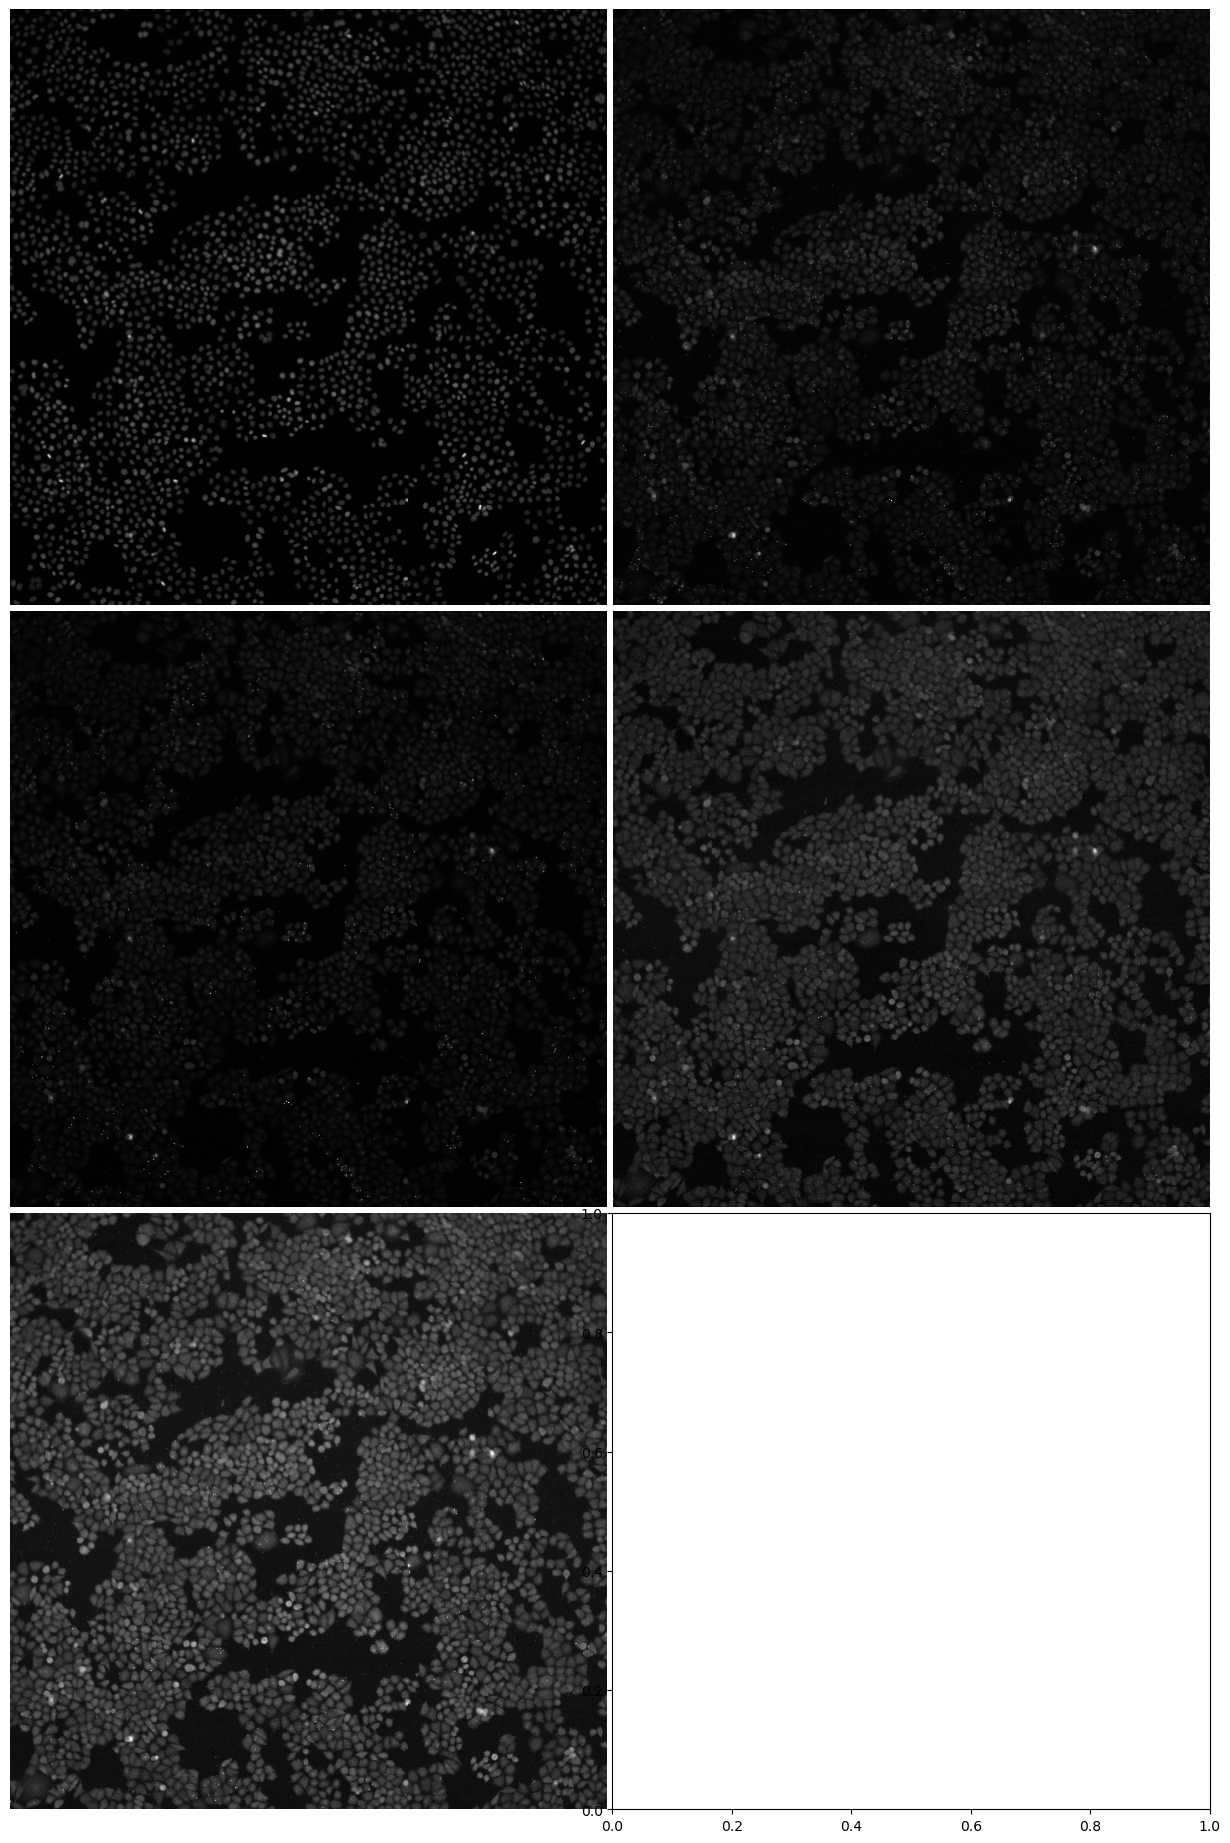

In [ ]:
# Convert test sbs sample to tiff
sbs_image = nd2_to_tiff(sbs_samples["sample_fp"][0], SBS_CHANNEL_ORDER_FLIP)

# Create micropanel to display converted samples
print("Converted SBS test sample:")
sbs_microimages = [Microimage(image) for image in sbs_image]
sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
plt.show()

### Test phenotype conversion

Converted phenotype test sample:


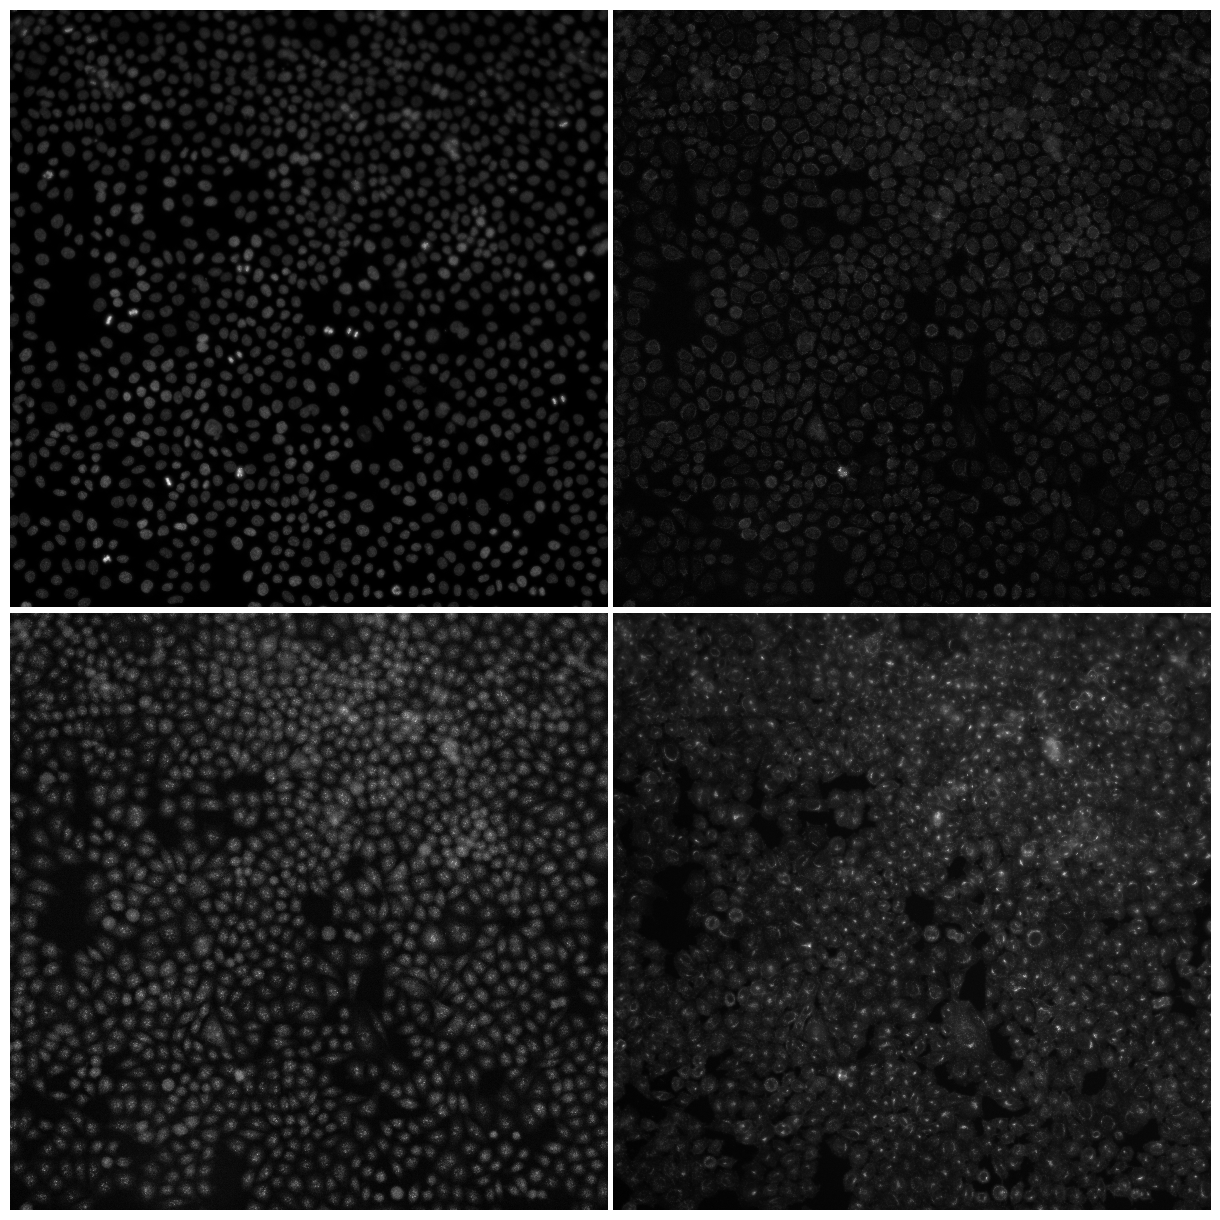

In [ ]:
# Convert test phenotype sample to tiff
phenotype_image = nd2_to_tiff(phenotype_samples["sample_fp"][0], PHENOTYPE_CHANNEL_ORDER_FLIP)

# Create micropanel to display converted samples
print("Converted phenotype test sample:")
phenotype_microimages = [Microimage(image) for image in phenotype_image]
phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
plt.show()

## Create config file with params

In [10]:
# Create empty config variable
config = {}

# Add all section
config["all"] = {
    "root_fp": ROOT_FP,
}

# Add preprocess section
config["preprocess"] = {
    "sbs_samples_fp": SBS_SAMPLES_DF_FP,
    "phenotype_samples_fp": PHENOTYPE_SAMPLES_DF_FP,
    "sbs_z_interval": SBS_Z_INTERVAL,
    "phenotype_z_interval": PHENOTYPE_Z_INTERVAL,
    "sbs_channel_order_flip": SBS_CHANNEL_ORDER_FLIP,
    "phenotype_channel_order_flip": PHENOTYPE_CHANNEL_ORDER_FLIP,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)